# import pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum,countDistinct,when, corr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("churn").getOrCreate()

In [3]:
# Read the CSV file into a DataFrame
df = spark.read.csv("./Customer-Churn-Records.csv", header=True, inferSchema=True)

# Show the content of the DataFrame
df.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Complain|Satisfaction Score|Card Type|Point Earned|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|       1|                 2|  DIAMOND|         464|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|       1|                 3|  DIAMOND|         456|
|        3|  1561930

In [4]:

# Calculate null counts for each column
exprs = [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]

# Use agg method to calculate total null counts
total_null_counts = df.agg(*exprs)

# Show the total null counts
total_null_counts.show()

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Complain|Satisfaction Score|Card Type|Point Earned|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|       0|                 0|        0|           0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+



In [5]:
df.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Complain|Satisfaction Score|Card Type|Point Earned|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|       1|                 2|  DIAMOND|         464|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|       1|                 3|  DIAMOND|         456|
|        3|  1561930

In [6]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- Complain: integer (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Card Type: string (nullable = true)
 |-- Point Earned: integer (nullable = true)



In [7]:
summary = df.describe()
summary.show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+------------------+---------+------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|            Exited|          Complain|Satisfaction Score|Card Type|      Point Earned|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+------------------+---------+------------------+
|  count|             10000|            10000|  10000|            10000| 

In [8]:
columns_to_drop = ["RowNumber", "CustomerId", "Surname"]
df = df.select([col for col in df.columns if col not in columns_to_drop])

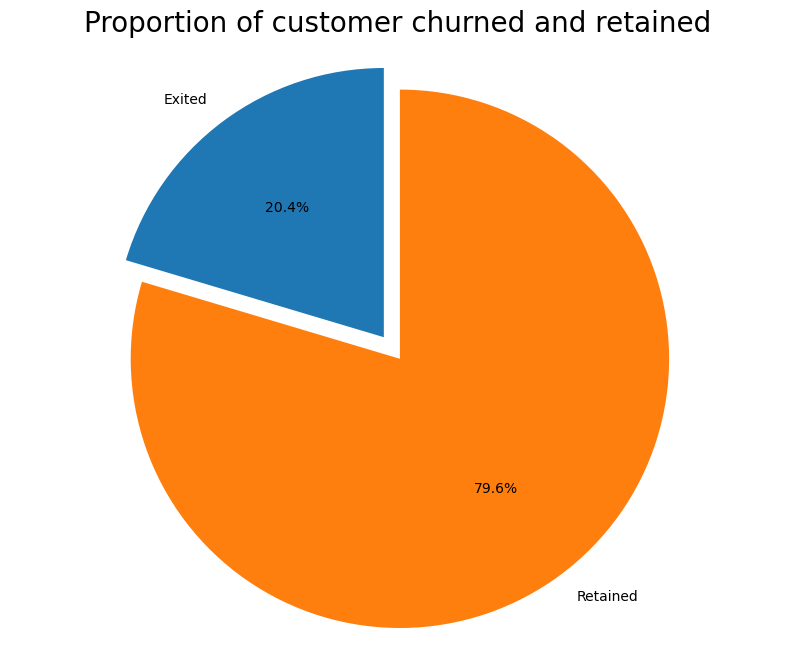

In [9]:
exited_count = df.filter(col('Exited') == 1).count()
retained_count = df.filter(col('Exited') == 0).count()

# Data for the pie chart
sizes = [exited_count, retained_count]
labels = ['Exited', 'Retained']
explode = (0, 0.1)

# Create a pie chart
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size=20)
plt.show()

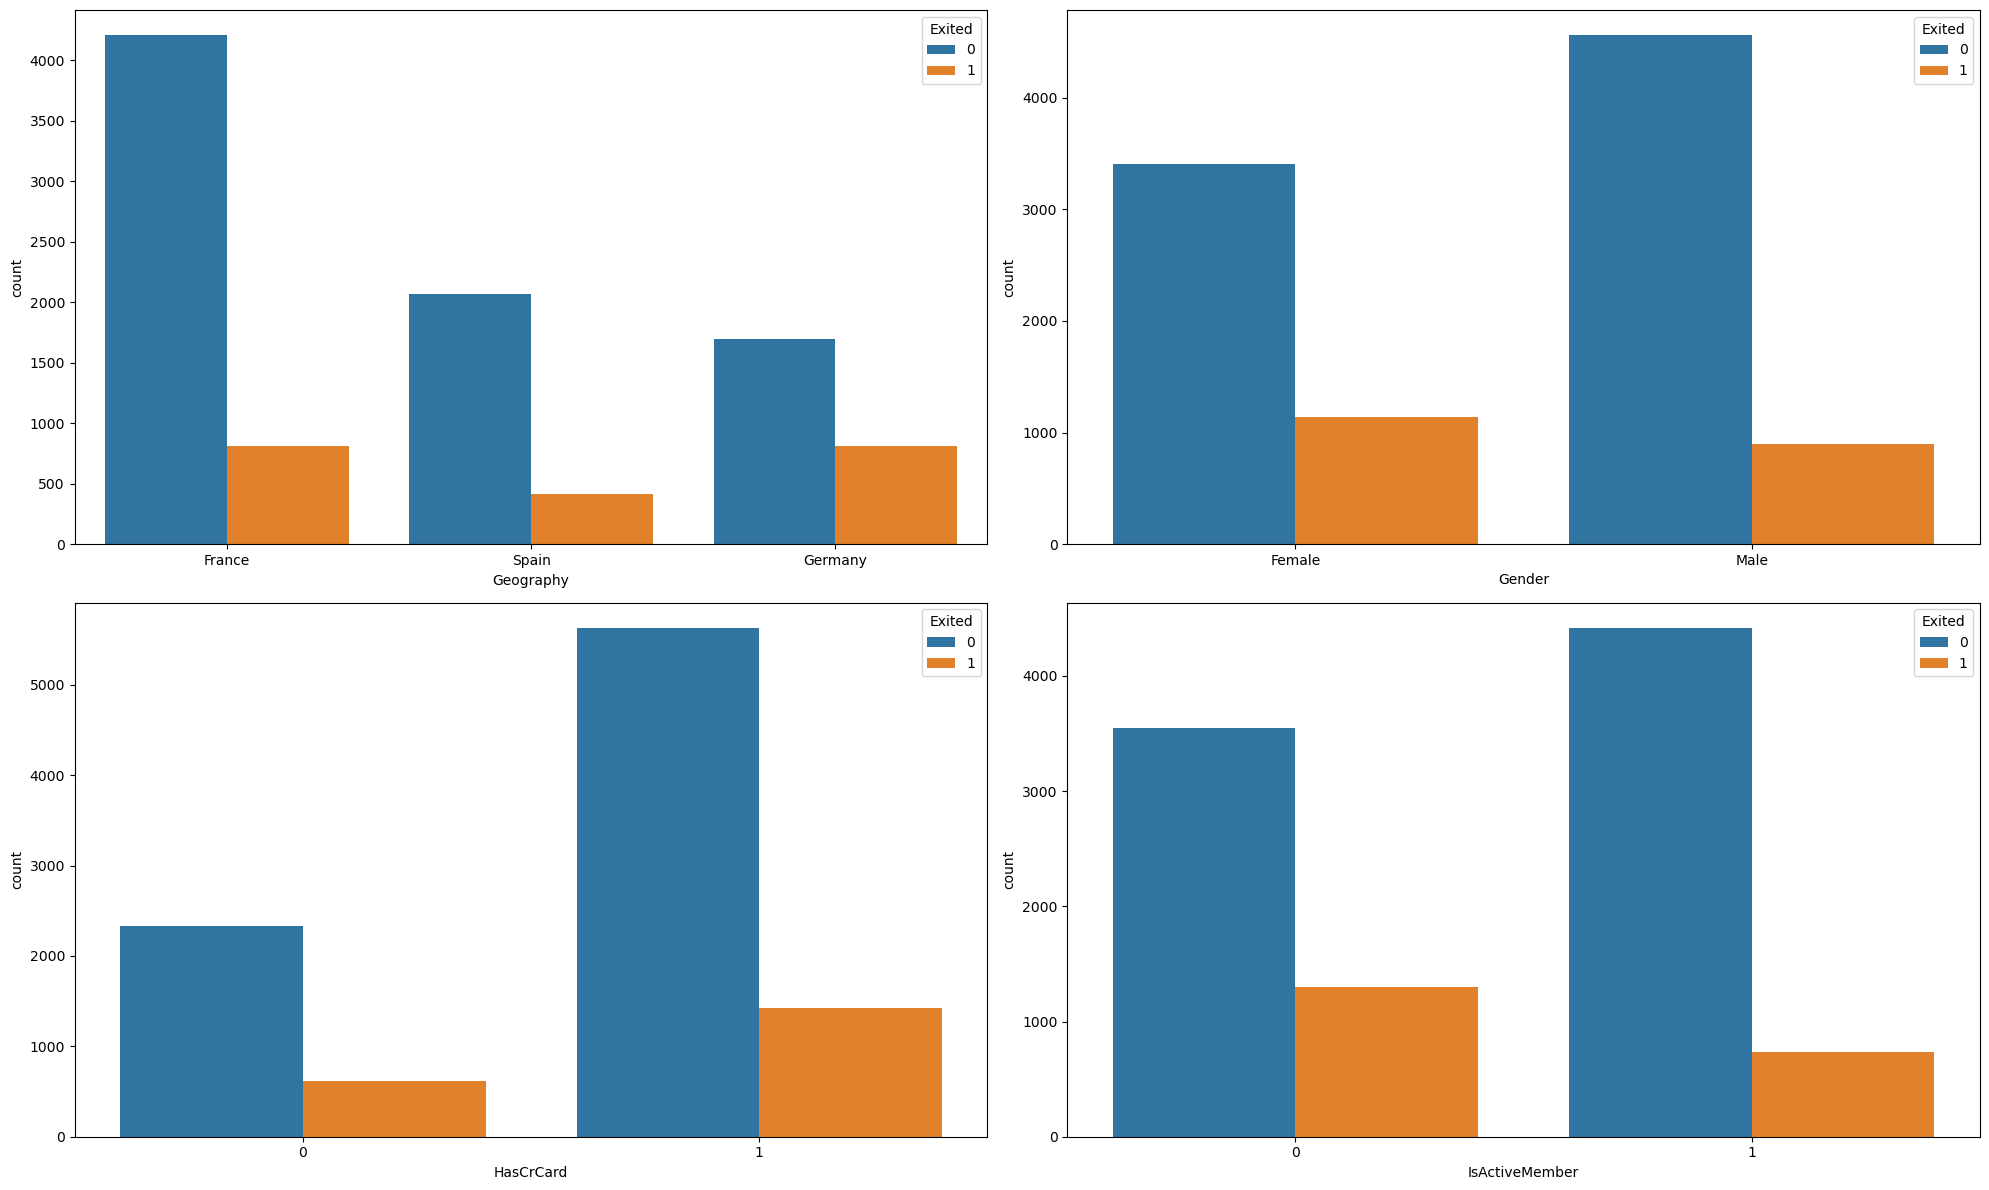

In [10]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))

# Subplot 1
sns.countplot(x='Geography', hue='Exited', data=df.toPandas(), ax=axarr[0, 0])

# Subplot 2
sns.countplot(x='Gender', hue='Exited', data=df.toPandas(), ax=axarr[0, 1])

# Subplot 3
sns.countplot(x='HasCrCard', hue='Exited', data=df.toPandas(), ax=axarr[1, 0])

# Subplot 4
sns.countplot(x='IsActiveMember', hue='Exited', data=df.toPandas(), ax=axarr[1, 1])

# Adjust layout
plt.tight_layout()

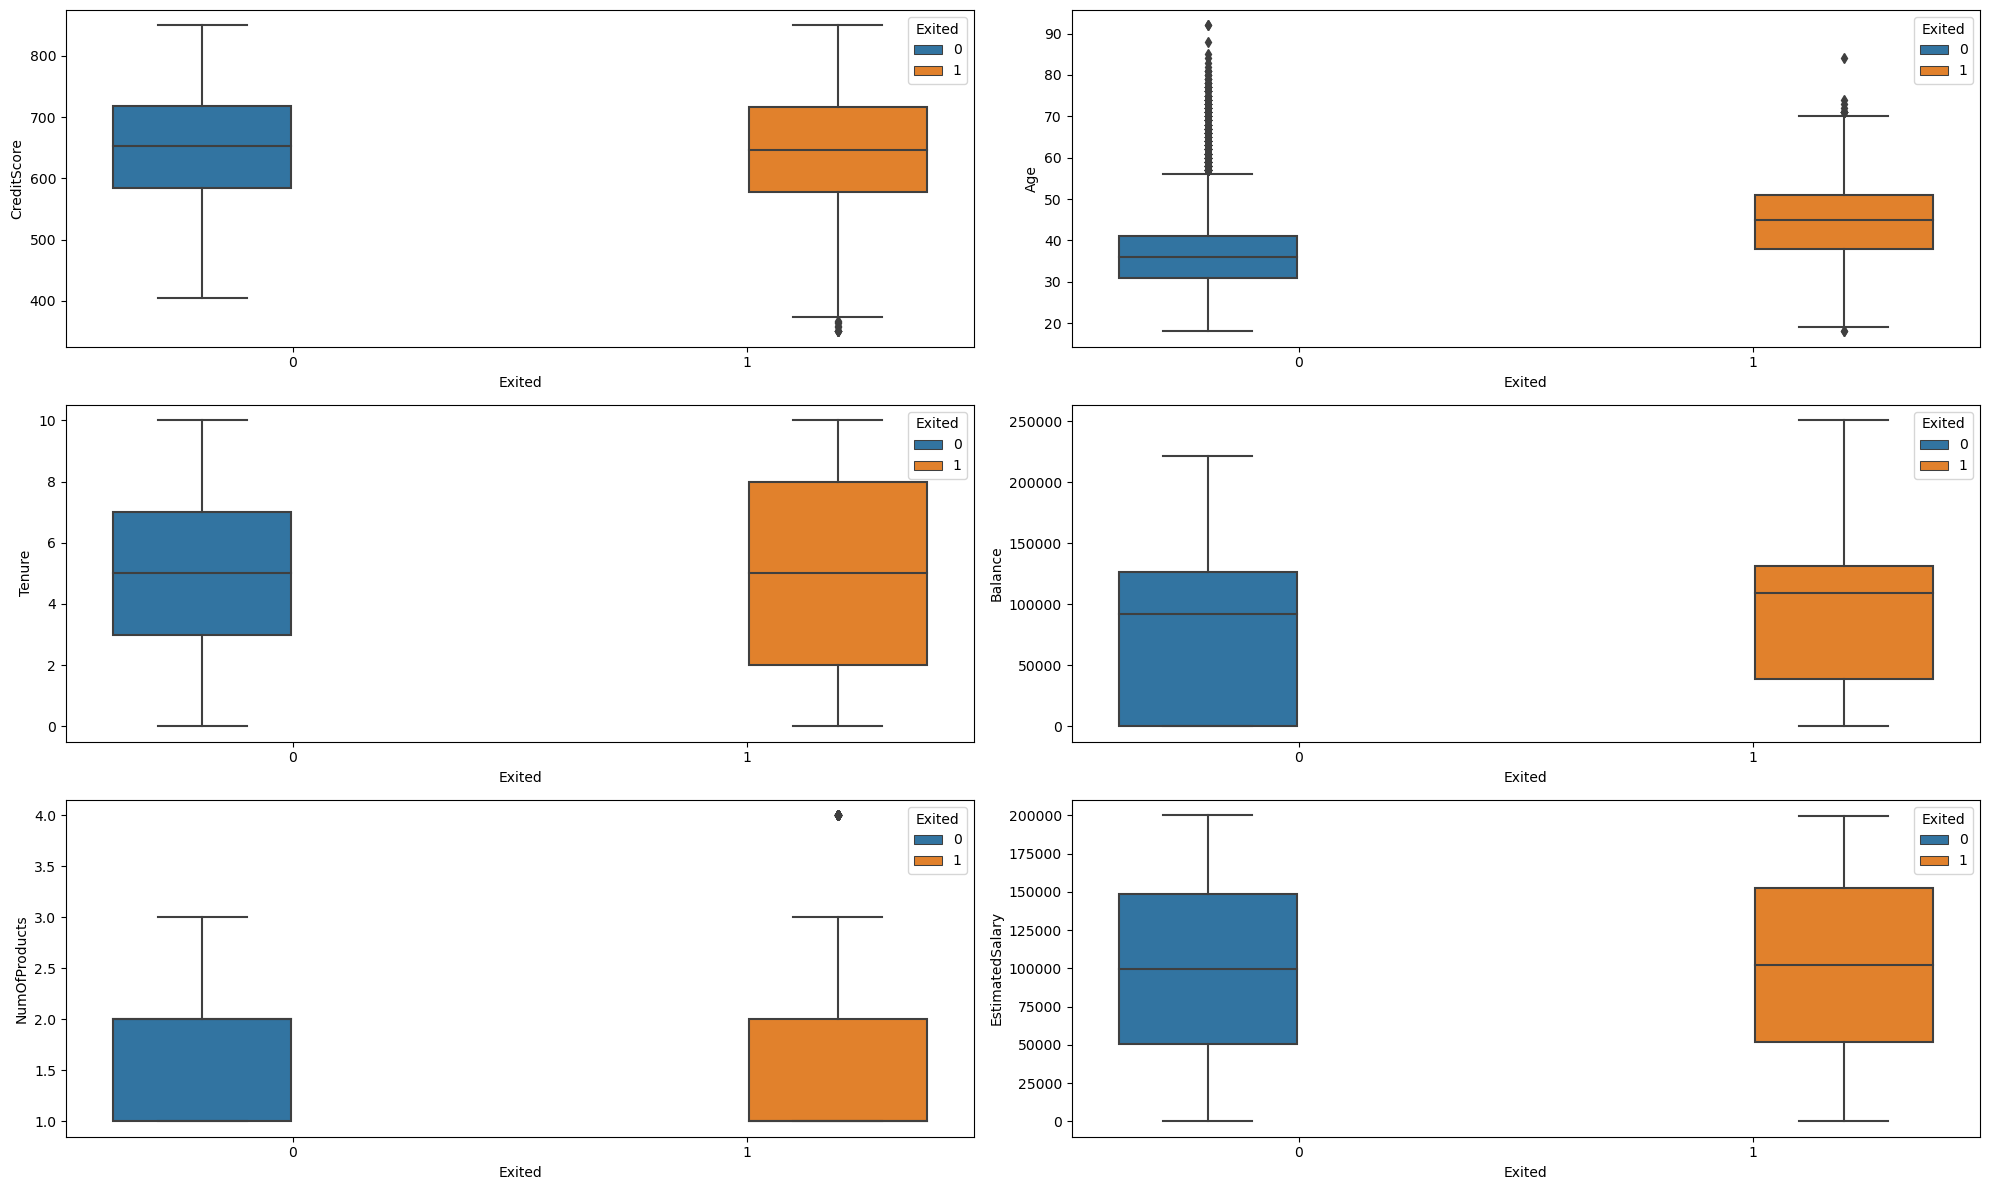

In [11]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))

# Subplot 1
sns.boxplot(y='CreditScore', x='Exited', hue='Exited', data=df.toPandas(), ax=axarr[0, 0])

# Subplot 2
sns.boxplot(y='Age', x='Exited', hue='Exited', data=df.toPandas(), ax=axarr[0, 1])

# Subplot 3
sns.boxplot(y='Tenure', x='Exited', hue='Exited', data=df.toPandas(), ax=axarr[1, 0])

# Subplot 4
sns.boxplot(y='Balance', x='Exited', hue='Exited', data=df.toPandas(), ax=axarr[1, 1])

# Subplot 5
sns.boxplot(y='NumOfProducts', x='Exited', hue='Exited', data=df.toPandas(), ax=axarr[2, 0])

# Subplot 6
sns.boxplot(y='EstimatedSalary', x='Exited', hue='Exited', data=df.toPandas(), ax=axarr[2, 1])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [12]:
column_names = df.columns
print(column_names)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned']


In [13]:
column_types = df.dtypes

# Filter columns based on data type (exclude 'number' types)
non_numeric_columns = [col_name for col_name, col_type in column_types if not col_type.startswith('decimal') and not col_type.startswith('double') and not col_type.startswith('float')]

# Print the non-numeric column names
print(non_numeric_columns)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned']


In [14]:
unique_counts = df.agg(*(countDistinct(col).alias(col) for col in df.columns))
unique_counts.show()

+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Complain|Satisfaction Score|Card Type|Point Earned|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|        460|        3|     2| 70|    11|   6382|            4|        2|             2|           9999|     2|       2|                 5|        4|         785|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+



In [15]:
geography_mapping = {'France': 0, 'Spain': 1, 'Germany': 2}
for geo_value, mapped_value in geography_mapping.items():
    df = df.withColumn("Geography", when(col("Geography") == geo_value, mapped_value).otherwise(col("Geography")))

df = df.withColumn("Geography", col("Geography").cast("int"))

In [16]:
gender_mapping = {'Male': 0, 'Female': 1}

# Apply the mapping using the 'when' function
for gender_value, mapped_value in gender_mapping.items():
    df = df.withColumn("Gender", when(col("Gender") == gender_value, mapped_value).otherwise(col("Gender")))

# Convert the column to integer type
df = df.withColumn("Gender", col("Gender").cast("int"))

In [17]:
card_type_mapping = {'DIAMOND': 0, 'GOLD': 1, 'SILVER': 2, 'PLATINUM': 3}

# Apply the mapping using the 'when' function
for card_type_value, mapped_value in card_type_mapping.items():
    df = df.withColumn("Card Type", when(col("Card Type") == card_type_value, mapped_value).otherwise(col("Card Type")))

# Convert the column to integer type
df = df.withColumn("Card Type", col("Card Type").cast("int"))

In [18]:
df.show()

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Complain|Satisfaction Score|Card Type|Point Earned|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------+------------------+---------+------------+
|        619|        0|     1| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|       1|                 2|        0|         464|
|        608|        1|     1| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|       1|                 3|        0|         456|
|        502|        0|     1| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|       1|                 3|        0|         377|
|        6

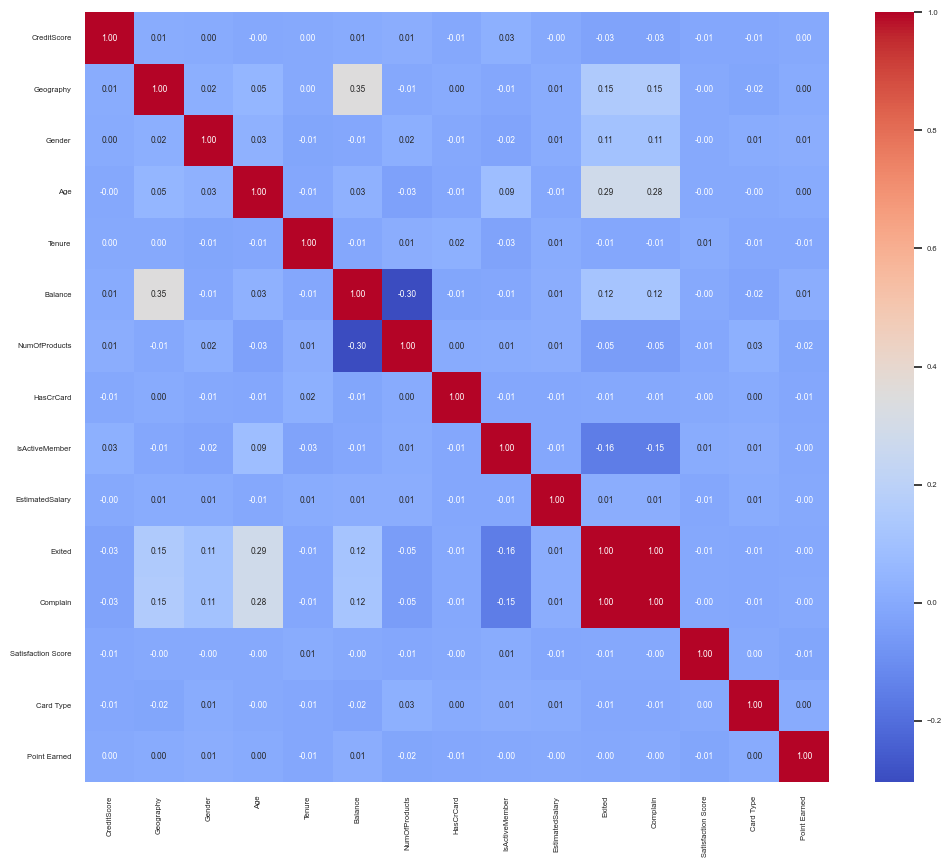

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd 

# Assuming 'df' is your PySpark DataFrame
# Specify the columns you want to calculate correlations for
selected_columns = df.columns

# Use VectorAssembler to assemble the selected columns into a single feature column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
assembled_df = assembler.transform(df).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").collect()[0][0]

# Convert the correlation matrix to a Pandas DataFrame for plotting
correlation_pd = pd.DataFrame(correlation_matrix.toArray(), columns=selected_columns, index=selected_columns)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.5)
sns.heatmap(correlation_pd, annot=True, fmt="0.2f", cmap="coolwarm")
plt.show()

In [20]:
# Assuming 'df' is your PySpark DataFrame
# Specify the column you want to calculate correlations for
selected_column = 'Exited'

# Calculate the correlations with the 'Exited' column
correlations = {}
for column in df.columns:
    if column != selected_column:
        correlation_value = df.corr(column, selected_column)
        correlations[column] = correlation_value

# Convert the dictionary to a Pandas Series for sorting
correlation_series = pd.Series(correlations, name=selected_column).sort_values(ascending=False)

# Display the sorted correlation values
print(correlation_series)

Complain              0.995693
Age                   0.285296
Geography             0.153518
Balance               0.118577
Gender                0.106267
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Card Type            -0.009484
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
IsActiveMember       -0.156356
Name: Exited, dtype: float64


In [21]:


# Sort the Pandas DataFrame by correlation values in descending order
sorted_correlation = correlation_pd['Exited'].sort_values(ascending=False)


In [22]:
columns_to_drop = ['Complain', 'Point Earned', 'Satisfaction Score', 'HasCrCard', 'Card Type']

# Select columns to keep
df = df.select([col(column) for column in df.columns if column not in columns_to_drop])

# Show the updated DataFrame
df.show()

+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|        619|        0|     1| 42|     2|      0.0|            1|             1|      101348.88|     1|
|        608|        1|     1| 41|     1| 83807.86|            1|             1|      112542.58|     0|
|        502|        0|     1| 42|     8| 159660.8|            3|             0|      113931.57|     1|
|        699|        0|     1| 39|     1|      0.0|            2|             0|       93826.63|     0|
|        850|        1|     1| 43|     2|125510.82|            1|             1|        79084.1|     0|
|        645|        1|     0| 44|     8|113755.78|            2|             0|      149756.71|     1|
|        822|        0|     0| 50|     7|      0.0|            2

In [23]:
X = df.drop('Exited')

# Select the 'Exited' column as the label
y = df.select('Exited').withColumnRenamed('Exited', 'Exited')

# Display the resulting DataFrames
X.show()
y.show()


+-----------+---------+------+---+------+---------+-------------+--------------+---------------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|IsActiveMember|EstimatedSalary|
+-----------+---------+------+---+------+---------+-------------+--------------+---------------+
|        619|        0|     1| 42|     2|      0.0|            1|             1|      101348.88|
|        608|        1|     1| 41|     1| 83807.86|            1|             1|      112542.58|
|        502|        0|     1| 42|     8| 159660.8|            3|             0|      113931.57|
|        699|        0|     1| 39|     1|      0.0|            2|             0|       93826.63|
|        850|        1|     1| 43|     2|125510.82|            1|             1|        79084.1|
|        645|        1|     0| 44|     8|113755.78|            2|             0|      149756.71|
|        822|        0|     0| 50|     7|      0.0|            2|             1|        10062.8|
|        376|        2|     1|

In [24]:

df.show()

+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|        619|        0|     1| 42|     2|      0.0|            1|             1|      101348.88|     1|
|        608|        1|     1| 41|     1| 83807.86|            1|             1|      112542.58|     0|
|        502|        0|     1| 42|     8| 159660.8|            3|             0|      113931.57|     1|
|        699|        0|     1| 39|     1|      0.0|            2|             0|       93826.63|     0|
|        850|        1|     1| 43|     2|125510.82|            1|             1|        79084.1|     0|
|        645|        1|     0| 44|     8|113755.78|            2|             0|      149756.71|     1|
|        822|        0|     0| 50|     7|      0.0|            2

In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from sklearn.metrics import accuracy_score

# Assuming 'spark' is your SparkSession
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming 'df' is your PySpark DataFrame
# Assuming 'Exited' is the column to be predicted

# VectorAssembler to assemble features into a single vector column
feature_columns = [c for c in df.columns if c != 'Exited']  # Exclude the 'Exited' column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(df).select("features", col("Exited").alias("label"))

# Split the data into training and testing sets
train_ratio = 0.7
test_ratio = 1.0 - train_ratio
seed = 0  # Set a seed for reproducibility
train_data, test_data = assembled_df.randomSplit([train_ratio, test_ratio], seed=seed)

# Logistic Regression model
logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")

# Create a Pipeline with the VectorAssembler and Logistic Regression
pipeline = Pipeline(stages=[assembler, logistic_regression])

# Fit the model on the training data
model = logistic_regression.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Convert predictions to a Pandas DataFrame for scikit-learn compatibility
y_pred = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Convert the 'label' column to a Pandas DataFrame
y_test_pd = test_data.select("label").rdd.map(lambda x: x[0]).collect()

# Calculate accuracy using scikit-learn's accuracy_score
accuracy = accuracy_score(y_test_pd, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.8033854166666666


Accuracy: 0.8033854166666666


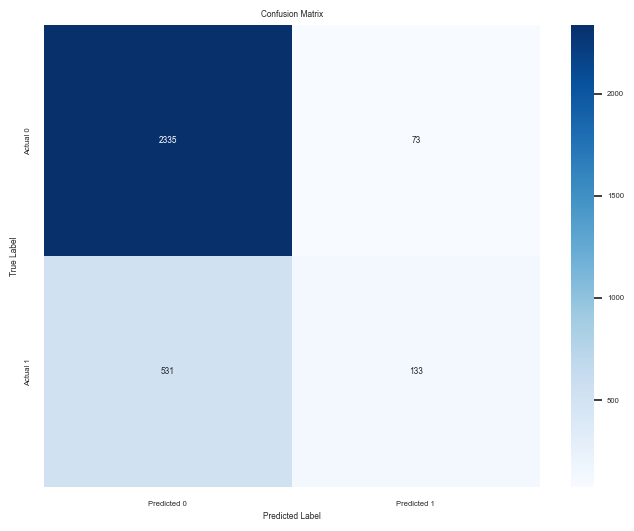

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from pyspark.sql.functions import col

test_data = test_data.withColumn("label", col("label").cast("double"))

# Make predictions on the test data
predictions = model.transform(test_data)

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Get the accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Create a confusion matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)

# Get confusion matrix in Spark's format
confusion_matrix_spark = metrics.confusionMatrix().toArray()

# Convert Spark's confusion matrix to a Pandas DataFrame for easier visualization
confusion_matrix_df = pd.DataFrame(confusion_matrix_spark, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

evaluator_roc_lr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc_roc_lr = evaluator_roc_lr.evaluate(predictions)
print("Logistic Regression - AUC-ROC:", auc_roc_lr)

# Create a BinaryClassificationEvaluator for AUC-PR
evaluator_pr_lr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderPR")
auc_pr_lr = evaluator_pr_lr.evaluate(predictions)
print("Logistic Regression - AUC-PR:", auc_pr_lr)

# Calculate precision, recall, and F1 score using scikit-learn
y_true_lr = test_data.select("label").rdd.map(lambda x: x[0]).collect()
y_pred_lr = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

precision_lr = precision_score(y_true_lr, y_pred_lr)
recall_lr = recall_score(y_true_lr, y_pred_lr)
f1_lr = f1_score(y_true_lr, y_pred_lr)

print("Logistic Regression - Precision:", precision_lr)
print("Logistic Regression - Recall:", recall_lr)
print("Logistic Regression - F1 Score:", f1_lr)


Logistic Regression - AUC-ROC: 0.8173245306808633
Logistic Regression - AUC-PR: 0.6386711476116396
Logistic Regression - Precision: 0.7977941176470589
Logistic Regression - Recall: 0.32680722891566266
Logistic Regression - F1 Score: 0.46367521367521364


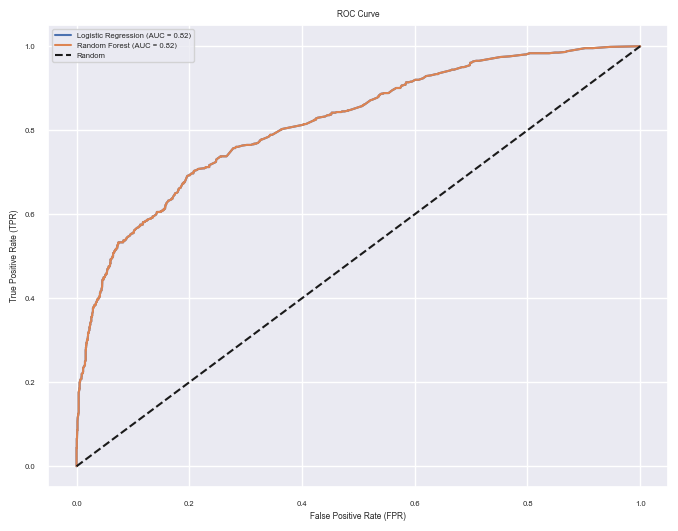

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'predictions' DataFrame for Logistic Regression is already available
# If not, replace it with the DataFrame containing your Logistic Regression model predictions
y_true_lr = test_data.select("label").rdd.map(lambda x: x[0]).collect()
y_score_lr = predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()

# Assuming 'predictions_rf' DataFrame for Random Forest is already available
# If not, replace it with the DataFrame containing your Random Forest model predictions
y_true_rf = test_data.select("label").rdd.map(lambda x: x[0]).collect()
y_score_rf = predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()

# Compute ROC curve values
fpr_lr, tpr_lr, _ = roc_curve(y_true_lr, y_score_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_true_rf, y_score_rf)

# Compute AUC for better representation in the legend
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [30]:
from pyspark.sql import SparkSessionb
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from sklearn.metrics import accuracy_score

# Assuming 'spark' is your SparkSession
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming 'df' is your PySpark DataFrame
# Assuming 'Exited' is the column to be predicted

# VectorAssembler to assemble features into a single vector column
feature_columns = [c for c in df.columns if c != 'Exited']  # Exclude the 'Exited' column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(df).select("features", col("Exited").alias("label"))

# Split the data into training and testing sets
train_ratio = 0.7
test_ratio = 1.0 - train_ratio
seed = 0  # Set a seed for reproducibility
train_data, test_data = assembled_df.randomSplit([train_ratio, test_ratio], seed=seed)

# Random Forest model
random_forest = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)  # You can adjust the number of trees as needed

# Create a Pipeline with the VectorAssembler and Random Forest
pipeline = Pipeline(stages=[assembler, random_forest])

# Fit the model on the training data
model = random_forest.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Convert predictions to a Pandas DataFrame for scikit-learn compatibility
y_pred = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Convert the 'label' column to a Pandas DataFrame
y_test_pd = test_data.select("label").rdd.map(lambda x: x[0]).collect()

# Calculate accuracy using scikit-learn's accuracy_score
accuracy = accuracy_score(y_test_pd, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.8365885416666666


Accuracy: 0.8365885416666666


D:\Anaconda\lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


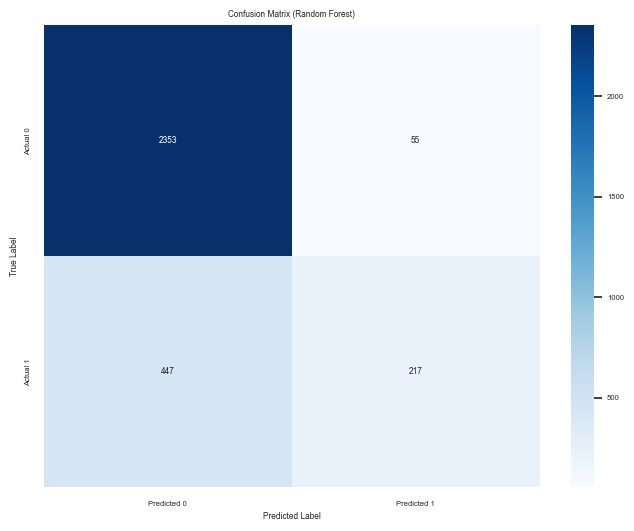

In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Convert the 'label' column to DoubleType for Random Forest
test_data = test_data.withColumn("label", col("label").cast("double"))

# Make predictions on the test data
predictions = model.transform(test_data)

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Get the accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Create a confusion matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)

# Get confusion matrix in Spark's format
confusion_matrix_spark = metrics.confusionMatrix().toArray()

# Convert Spark's confusion matrix to a Pandas DataFrame for easier visualization
confusion_matrix_df = pd.DataFrame(confusion_matrix_spark, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [33]:
evaluator_roc_rf = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc_roc_rf = evaluator_roc_rf.evaluate(predictions)
print("Random Forest Classifier - AUC-ROC:", auc_roc_rf)

# Create a BinaryClassificationEvaluator for AUC-PR
evaluator_pr_rf = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderPR")
auc_pr_rf = evaluator_pr_rf.evaluate(predictions)
print("Random Forest Classifier - AUC-PR:", auc_pr_rf)

# Calculate precision, recall, and F1 score using scikit-learn
y_true_rf = test_data.select("label").rdd.map(lambda x: x[0]).collect()
y_pred_rf = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

precision_rf = precision_score(y_true_rf, y_pred_rf)
recall_rf = recall_score(y_true_rf, y_pred_rf)
f1_rf = f1_score(y_true_rf, y_pred_rf)

print("Random Forest Classifier - Precision:", precision_rf)
print("Random Forest Classifier - Recall:", recall_rf)
print("Random Forest Classifier - F1 Score:", f1_rf)


Random Forest Classifier - AUC-ROC: 0.8173245306808633
Random Forest Classifier - AUC-PR: 0.6386711476116396
Random Forest Classifier - Precision: 0.7977941176470589
Random Forest Classifier - Recall: 0.32680722891566266
Random Forest Classifier - F1 Score: 0.46367521367521364


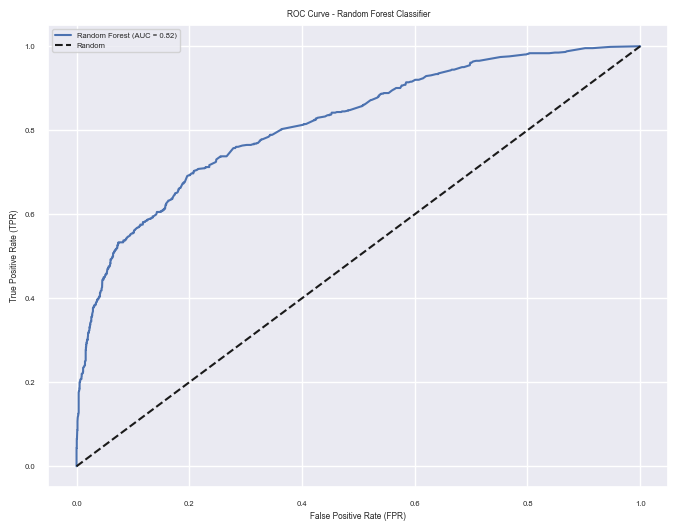

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'predictions' DataFrame for Random Forest is already available
# If not, replace it with the DataFrame containing your Random Forest model predictions
y_true_rf = predictions.select("label").rdd.map(lambda x: x[0]).collect()
y_score_rf = predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()

# Compute ROC curve values
fpr_rf, tpr_rf, _ = roc_curve(y_true_rf, y_score_rf)

# Compute AUC for better representation in the legend
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend()
plt.show()
